In [1]:
import os
import math
import time
import glob
import pathlib
from natsort import natsorted
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
import tensorflow_gan as tfgan
from IPython import display
from PIL import Image
from functools import reduce

tf.compat.v1.enable_eager_execution()

W0909 20:42:42.842136 25164 module_wrapper.py:137] From D:\ProgramData\Anaconda3\envs\cv\lib\site-packages\tensorflow_gan\python\contrib_utils.py:305: The name tf.estimator.tpu.TPUEstimator is deprecated. Please use tf.compat.v1.estimator.tpu.TPUEstimator instead.



In [2]:
def load_images_as_tensor(files):
    files = [file.decode('utf8') for file in files.numpy()]
    images = np.asarray([np.asarray(Image.open(file)) for file in files])
    images_tensor = tf.convert_to_tensor(images)
    return images_tensor

def load_dataset(data_root, window_size=5, batch_size=1, shuffle=True, prefetch=1):
    directories = list({os.path.dirname(file) for file in data_root.rglob('*.tiff')})
    files = [natsorted(map(str, pathlib.Path(d).glob('*.tiff'))) for d in directories]
    datasets = [tf.data.Dataset.from_generator(lambda f=f: f, 'string') for f in files]
    datasets = [d.window(window_size, shift=1, drop_remainder=True).flat_map(lambda x: x.batch(window_size)) for d in datasets]
    dataset = reduce(lambda d1, d2: d1.concatenate(d2), datasets)

    if shuffle:
        dataset = dataset.shuffle(50000)
    dataset = dataset.map(lambda files: tf.py_function(load_images_as_tensor, [files], Tout=tf.float32))
    dataset = dataset.map(lambda e: tf.transpose(e, perm=[1, 2, 0]))  # Convert CHW to HWC
    if batch_size:
        dataset = dataset.batch(batch_size)
    if prefetch:
        dataset = dataset.prefetch(prefetch)
    return dataset

In [3]:
# Input
DATA_ROOT = "../data/images/edm"
SHUFFLE = True
PREFETCH = 1

# Hyperparameters
WINDOW_SIZE = 1
BATCH_SIZE = 1
NUM_CONV = 2
LATENT_DIM = 32
EPOCHS = 500

# Output
EXAMPLES_TO_GENERATE = 16
OUTPUT_DIR = "../data/output/images"

In [4]:
train_root = pathlib.Path(os.path.join(DATA_ROOT, 'train'))
test_root = pathlib.Path(os.path.join(DATA_ROOT, 'test'))
train_dataset = load_dataset(train_root, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE, shuffle=SHUFFLE, prefetch=PREFETCH)
test_dataset = load_dataset(test_root, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE, shuffle=SHUFFLE, prefetch=PREFETCH)

In [5]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim, num_conv=2, input_shape=(512, 512, WINDOW_SIZE)):
        super().__init__()
        self.latent_dim = latent_dim
        self.inference_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=input_shape),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation='relu',
                ),
                *[tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation='relu'
                ) for i in range(num_conv)],
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(2 * latent_dim)
            ], name="Encoder"
        )

        decoder_input_shape = (
            input_shape[0] // (2 ** (num_conv + 1)),
            input_shape[1] // (2 ** (num_conv + 1)),
            64
        )

        self.generative_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim, )),
                tf.keras.layers.Dense(
                    decoder_input_shape[0] * decoder_input_shape[1] * decoder_input_shape[2],
                    activation=tf.nn.relu
                ),
                tf.keras.layers.Reshape(target_shape=decoder_input_shape),
                *[tf.keras.layers.Conv2DTranspose(
                    filters=64,
                    kernel_size=3,
                    strides=(2, 2),
                    padding='SAME',
                    activation='relu'
                ) for i in range(num_conv)],
                tf.keras.layers.Conv2DTranspose(
                    filters=32,
                    kernel_size=3,
                    strides=(2, 2),
                    padding='SAME',
                    activation='relu'
                ),
                tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=(1, 1), padding='SAME'
                )
            ], name="Decoder"
        )

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        inference = self.inference_net(x)
        mean, logvar = tf.split(inference, num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [6]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis
    )

@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [7]:

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(shape=[EXAMPLES_TO_GENERATE, LATENT_DIM])
model = CVAE(LATENT_DIM, num_conv=NUM_CONV)
model.inference_net.summary()
model.generative_net.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 255, 255, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 127, 127, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 254016)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                16257088  
Total params: 16,312,832
Trainable params: 16,312,832
Non-trainable params: 0
_________________________________________________________________
Model: "Decoder"
_________________________________________________________________
Layer (type)                 O

In [8]:
def generate_and_save_images(model, epoch, test_input):
    num_plots = math.ceil(math.sqrt(len(test_input)))
    predictions = model.sample(test_input)
    fig = plt.figure(figsize=(12, 12))
    fig.subplots_adjust(hspace=0, wspace=0)
    for i, pred in enumerate(predictions):
        plt.subplot(num_plots, num_plots, i + 1)
        plt.imshow(pred[:, :, 0], cmap='gray', vmin=0, vmax=1)
        plt.axis('off')
        output_dir = os.path.join(OUTPUT_DIR, 'progress', str(i))
        os.makedirs(output_dir, exist_ok=True)
        image = Image.fromarray(pred[:, :, 0].numpy(), mode='F')
        image.save(os.path.join(output_dir, f"epoch_{epoch}.tiff"))
    plt.show()

Epoch: 500 / 500 | Test set ELBO: -11557.7451171875 | Epoch time: 16.606608629226685


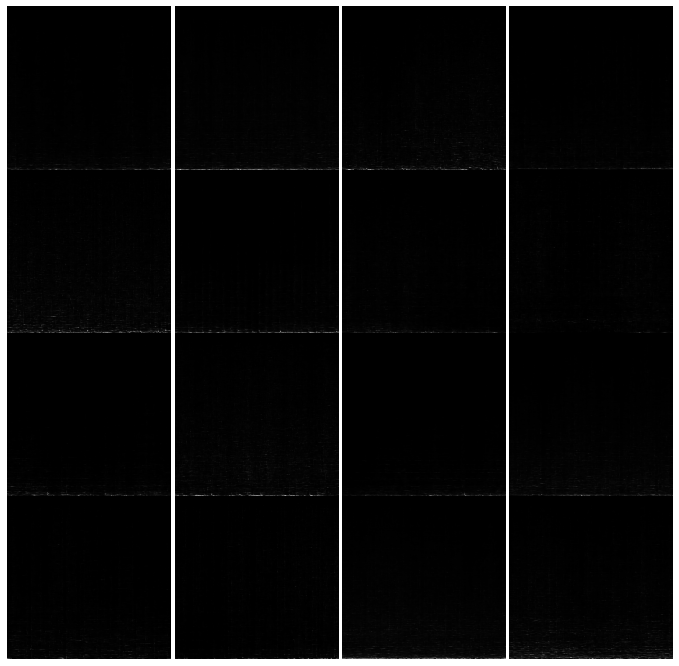

In [9]:
generate_and_save_images(model, 0, random_vector_for_generation)
plt.autoscale(enable=True)
for epoch in range(1, EPOCHS + 1):
    start_time = time.time()
    for x in train_dataset:
        compute_apply_gradients(model, x, optimizer)
    end_time = time.time()
    if epoch % 1 == 0:
        loss = tf.keras.metrics.Mean()
        for x in test_dataset:
            loss(compute_loss(model, x))
        elbo = -loss.result()
        display.clear_output(wait=False)
        print(f"Epoch: {epoch} / {EPOCHS} | Test set ELBO: {elbo} | Epoch time: {end_time - start_time}")
        generate_and_save_images(model, epoch, random_vector_for_generation)